In [1]:
%run model.ipynb

/anaconda3/envs/nd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/nd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/nd/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
model.ipynb:6: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(2, 2, padding="same")`
  "metadata": {},
model.ipynb:9: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(2, 2, padding="same")`
  "import pandas as pd\n",


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [2]:
import sys
sys.path.append('../preparations/')

In [3]:
import x01_generate_notes
import x02_generate_midi
import x03_generate_wav
import x04_generate_wav_processed
import x05_generate_spectrogram
import x06_generate_label

In [4]:
!mkdir notes
!mkdir midi
!mkdir wav
!mkdir wav_processed
!mkdir spectrogram
!mkdir label
!rm ./notes/*
!rm ./midi/*
!rm ./wav/*
!rm ./wav_processed/*
!rm ./spectrogram/*
!rm ./label/*

mkdir: notes: File exists
mkdir: midi: File exists
mkdir: wav: File exists
mkdir: wav_processed: File exists
mkdir: spectrogram: File exists
mkdir: label: File exists


In [5]:
import glob
files = glob.glob('../*.wav')
print(len(files))
for filename in files:
    print(filename)
    x05_generate_spectrogram.generate_spectrogram(filename)

1
../cover.wav


In [6]:
import soundfile as sf
import sounddevice as sd

audio, sr = sf.read(files[0])

sd.play(audio, samplerate=sr)

In [7]:
!ls ./spectrogram/

cover.npy


In [8]:
!ls ./notes/
!ls ./midi/
!ls ./wav/
!ls ./wav_processed/
!ls ./spectrogram/
!ls ./label/

cover.npy


In [9]:
import glob
import matplotlib.pyplot as plt

glob_spectrogram = glob.glob('./spectrogram/*')


In [10]:
for spectrogram_ in glob_spectrogram:
    
    spectrogram = np.load(spectrogram_)
    print(np.shape(spectrogram))
    print(np.shape(spectrogram[:,:]))
    cnn_inputs = np.array(list(zip([spectrogram[:,i:-108+i:27] for i in range(108)])))
    print(np.shape(cnn_inputs))
    cnn_inputs = np.swapaxes(cnn_inputs,0,3)
    print(np.shape(cnn_inputs))
    cnn_inputs = [cnn_input for cnn_input in cnn_inputs]
    print(np.shape(cnn_inputs[1]))
#     plt.imshow(cnn_inputs[7][0,:,:])
#     plt.colorbar()
#     plt.show()
    
print(np.shape(cnn_inputs))


(108, 73690)
(108, 73690)
(108, 1, 108, 2726)
(2726, 1, 108, 108)
(1, 108, 108)
(2726, 1, 108, 108)


(2726, 1, 108, 108)


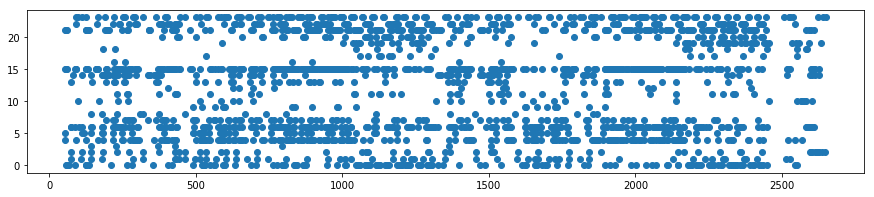

In [11]:
plt.figure(figsize=(15,3))
lstm_memory = np.zeros((1,20,24))
predicted_score = []

print(np.shape(cnn_inputs))
for i, cnn_input in enumerate(cnn_inputs):
    
#     print(np.shape(cnn_input))
#     print(np.shape(lstm_input))
#     give_prediction(classifier, np.zeros((1,20,24)), np.zeros((1,108,108,1)))
#     print(lstm_input[-1,-1])
#     print(result)
    result = give_prediction(classifier, lstm_memory, cnn_input.reshape((1,108,108,1)))
    lstm_memory[0,:-1] = np.copy(lstm_memory[0,1:])
    lstm_memory[0,-1] = np.copy(result)
    for j, note in enumerate(result[0]):
        if note != 0:
            predicted_score.append([i,j])

predicted_score = np.transpose(predicted_score)
plt.scatter(predicted_score[0], predicted_score[1], marker='o')            
plt.show()